<a href="https://colab.research.google.com/github/IG-Reagan/Predictive-Maintenance_Detecting-anomalous-activities-in-a-ship-engine/blob/main/Predictive_Maintenance_Detecting_the_Anomalous_Activity_of_a_Ship_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecting the anomalous activity of a ship's engine

This project developed a machine-learning-based predictive maintenance framework to detect anomalous behaviour in ship engine performance. The goal was to identify early warning signs of mechanical faults to reduce downtime, improve safety, and optimise operational efficiency across a commercial shipping fleet.

The dataset, provided by Devabrat (2022), captures real-world sensor readings from a ship’s main engine. It consists of 19,535 records with six continuous features: engine rpm, lubrication oil pressure, fuel pressure, coolant pressure, lubrication oil temperature, and coolant temperature. These variables reflect the mechanical and thermal conditions of the engine under different operating states.

Techniques applied include statistical outlier detection (IQR), **One-Class SVM**, and **Isolation Forest**, with dimensionality reduction via PCA for visualisation.  The **Isolation Forest** model achieved the most efficient and interpretable anomaly detection, identifying early fault patterns that can inform predictive maintenance decisions.

In [ ]:
# URL to import data set from GitHub.
# url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'

**1. Import Libraries and Dataset**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats

# Ignore warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import the data
url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv' # data source link assigned to url
data = pd.read_csv(url)
data.head(3)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806


**2. Data Exploration (EDA)**

In [ ]:
# View the data shape (number of records and features in the dataset)
data.shape

(19535, 6)

There are 6 features and 19,535 records of data in the dataset. Next we explore more information about the data.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


Viewing more information about the data shows 5 float type variables and 1 integer variable which is the rpm. This makes sense as revolutions per minute should be discrete. We can also see that there are no missing values in the dataset.

In [ ]:
# Check for duplicated rows
duplicated_rows = data.duplicated().sum()
print('Number of duplicated records: ', duplicated_rows)

Number of duplicated records:  0


**3. Descriptive Statistics**

In [ ]:
# View descriptive statistics
data.describe().round(2).T # Transposed for ease of viewing

,count,mean,std,min,25%,50%,75%,max
Engine rpm,19535.0,791.24,267.61,61.00,593.00,746.00,934.00,2239.00
Lub oil pressure,19535.0,3.30,1.02,0.00,2.52,3.16,4.06,7.27
Fuel pressure,19535.0,6.66,2.76,0.00,4.92,6.20,7.74,21.14
Coolant pressure,19535.0,2.34,1.04,0.00,1.60,2.17,2.85,7.48
lub oil temp,19535.0,77.64,3.11,71.32,75.73,76.82,78.07,89.58
Coolant temp,19535.0,78.43,6.21,61.67,73.90,78.35,82.92,195.53


The above descriptive statistics table show some maximum values that are more than double the 75th percentile; such as 'Engine rpm', 'Fuel pressure', 'Coolant pressure' and 'Coolant temp'. These could be an indication of an anomalies. Next step is to idenitfy the range of values beyond the 95th percentile for the mentioned features:

In [ ]:
# Calculate percentile for each feature in the dataset
percentile_dict = {}
for column in data.columns:
    ninety_fifth = round(data[column].quantile(0.95), 2)
    percentile_dict[column] = ninety_fifth

# Print result
print('95th Percentiles per column: \n')
percentile_dict

95th Percentiles per column: 



{'Engine rpm': 1324.0,
 'Lub oil pressure': 5.06,
 'Fuel pressure': 12.21,
 'Coolant pressure': 4.44,
 'lub oil temp': 84.94,
 'Coolant temp': 88.61}

In [ ]:
# View range of values above the 95th percentile for 'Engine rpm', 'Fuel pressure' and 'Coolant temp'

def data_beyond_95th_perc(data, col):
  """ function takes in a dataframe and column name and produces the range of values beyond the 95th percentile """
  threshold = percentile_dict[col]
  data_95th = data[data[col] > threshold]
  return f'Values above 95th perc - {threshold}, in {col}:', data_95th[col].sort_values()

In [ ]:
# Range of values beyond 95th percentile for Engine rpm
text, engine_rpm_above_95th = data_beyond_95th_perc(data, 'Engine rpm')
print(text)
print(engine_rpm_above_95th)

Values above 95th perc - 1324.0, in Engine rpm:
6245     1325
13263    1325
12739    1325
5014     1325
14691    1325
         ... 
9275     2151
10506    2163
13191    2172
7790     2191
15932    2239
Name: Engine rpm, Length: 974, dtype: int64


In [ ]:
# Range of values beyond 95th percentile for Fuel pressure
text, fuel_pressure_above_95th = data_beyond_95th_perc(data, 'Fuel pressure')
print(text)
print(fuel_pressure_above_95th)

Values above 95th perc - 12.21, in Fuel pressure:
10251    12.212177
8082     12.215352
8152     12.217096
12129    12.217721
8465     12.217730
           ...    
561      19.510172
9417     19.558918
8643     19.717281
13845    19.858917
9        21.138326
Name: Fuel pressure, Length: 977, dtype: float64


In [ ]:
# Range of values beyond 95th percentile for Coolant pressure
text, coolant_pressure_above_95th = data_beyond_95th_perc(data, 'Coolant pressure')
print(text)
print(coolant_pressure_above_95th)

Values above 95th perc - 4.44, in Coolant pressure:
12381    4.441296
4566     4.442517
7065     4.444453
5770     4.446391
5533     4.446646
           ...   
7744     7.211976
8620     7.263990
11672    7.417474
5859     7.425322
13910    7.478505
Name: Coolant pressure, Length: 975, dtype: float64


In [ ]:
# Range of values beyond 95th percentile for Coolant temp
text, coolant_temp_above_95th = data_beyond_95th_perc(data, 'Coolant temp')
print(text)
print(coolant_temp_above_95th)

Values above 95th perc - 88.61, in Coolant temp:
11042     88.612577
5815      88.613625
14523     88.614694
4713      88.619477
9894      88.620349
            ...    
16390     95.149178
1794      95.234554
17452     95.855283
3242     118.371957
10663    195.527912
Name: Coolant temp, Length: 978, dtype: float64


There are 974, 977, 975 and 978 values above the 95th percentile of 'Engine rpm', 'Fuel pressure', Coolant pressure and 'Coolant temp' features respectively.

**4. Visualise Data to Determine Distribution and Extreme Values**

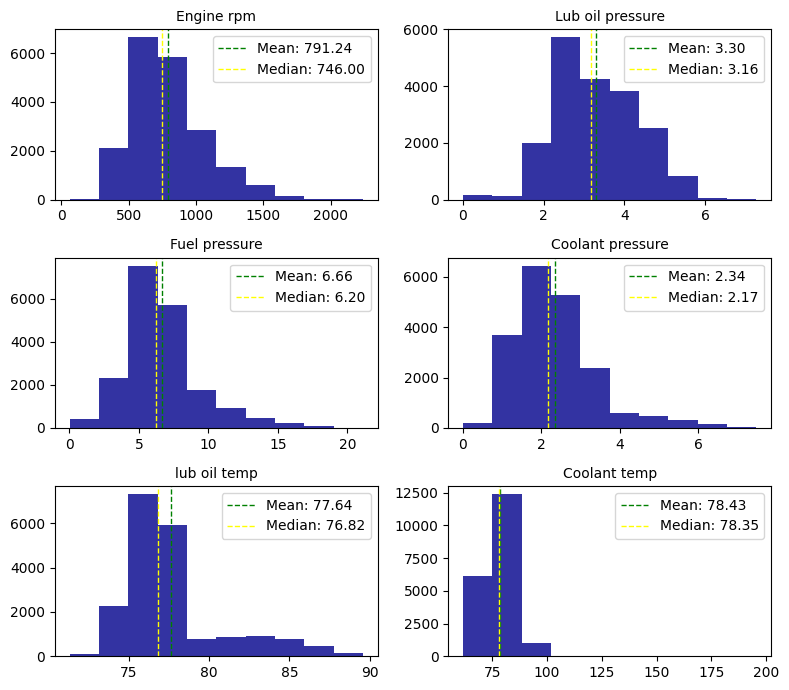

In [ ]:
# Create histograms showing mean and median lines to visualise the data distribution
fig, axes = plt.subplots(3, 2, figsize=(8, 7))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]

    # Plot histogram
    ax.hist(data[column], bins=10, alpha=0.8, color='darkblue')

    # Calculate mean and median
    mean_value = data[column].mean()
    median_value = data[column].median()

    # Add vertical lines for mean and median
    ax.axvline(mean_value, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f}')
    ax.axvline(median_value, color='yellow', linestyle='dashed', linewidth=1, label=f'Median: {median_value:.2f}')

    # Add title and legend
    ax.set_title(column, size=10)
    ax.legend()

# Show plot
plt.tight_layout()
plt.show()

From above histograms we can see that the means are slightly shifted to the right of the median, except 'Coolant temp' where the mean and median are nearly equal. This confirms that their values are skewed to the right as shown by the plots, resulting to higher mean values than medians. However, despite 'Coolant temp' have almost equal mean and median, there seem to be an anomaly (or a few) that is far removed from the rest of the data, hence also appearing right skewed.

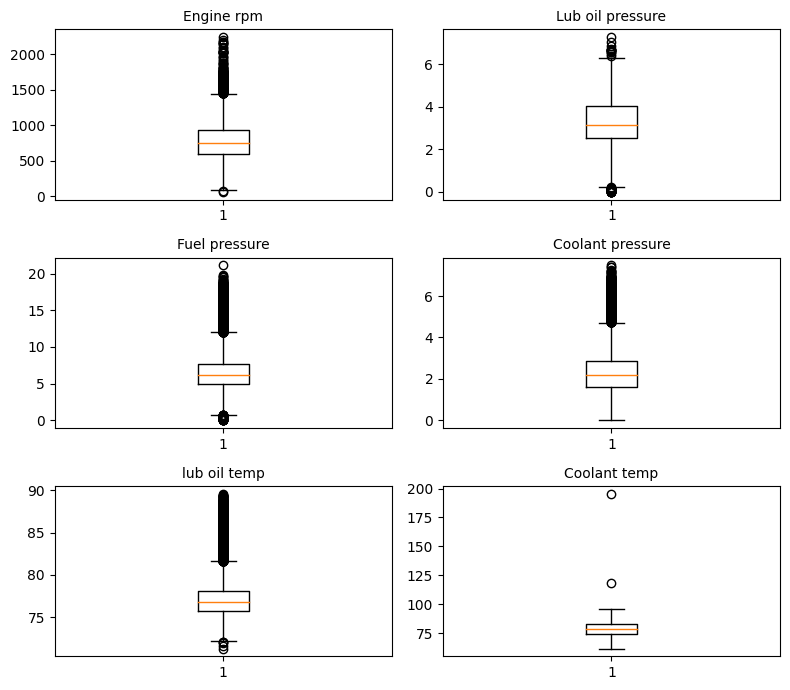

In [ ]:
# Create boxplots to view outliers and anomalies more clearly
fig, axes = plt.subplots(3, 2, figsize=(8, 7))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    ax = axes[i]

    # Plot boxplot
    ax.boxplot(data[column])

    # Add title and legend
    ax.set_title(column, size=10)

# Show plot
plt.tight_layout()
plt.show()

As expected, we can see two likely anomalies in 'Coolant temp' far removed from the other values. While there seem to also be outliers in the other features, it is difficult to tell if these outliers are anomalies unless a boundary has been set for which any values above can be safely classified as an anomaly.

**5. Perform anomaly detection with a statistical method and identify possible anomalies**

In [ ]:
# Create a function to compute the q1, q3, iqr, lower and uppper limits for each feature
def limits(data):
  """ function takes in a dataframe and outputs the lower and upper limits of all features in the dataframe based on IQR calculations """
  results = {}

  for col in data.columns:
      # Calculate the quantiles.
      q1 = data[col].quantile(0.25)
      q3 = data[col].quantile(0.75)

      # Compute and view the IQR.
      iqr = q3 - q1

      # Calculate the upper and lower limits.
      lower = q1-1.5*iqr
      upper = q3+1.5*iqr

      # Store the results in a dictionary
      result_dict = {'q1': q1, 'q3': q3, 'IQR': iqr, 'lower': lower, 'upper': upper}

      # Add the result dictionary to the main dictionary
      results[col] = result_dict

  return results

# Pass dataset into function to display the stats and limits
result = limits(data)
stats_table = round(pd.DataFrame(result), 2)
stats_table

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
q1,593.0,2.52,4.92,1.60,75.73,73.90
q3,934.0,4.06,7.74,2.85,78.07,82.92
IQR,341.0,1.54,2.83,1.25,2.35,9.02
lower,81.5,0.21,0.67,-0.27,72.21,60.37
upper,1445.5,6.36,11.99,4.72,81.59,96.45


Create a new column for each feature indicating (in binary – 0,1) if the value of that feature is an outlier as per IQR calculations

In [ ]:
# Define a function to generate new columns of outlier 1 or 0
def outliers_(data, col, new_col):
    """ Function takes in dataset and column name and returns a new column with 1 or 0 for each row value being an outlier or not """
    for i, row in data.iterrows():
        if row[col] < stats_table.loc['lower', col] or row[col] > stats_table.loc['upper', col]:
            data.at[i, new_col] = 1
        else: data.at[i, new_col] = 0
    return data

In [ ]:
# Use outlier_ function to produce new columns
outliers_(data, 'Engine rpm', 'Engine_rpm_outlier')
outliers_(data, 'Lub oil pressure', 'Lub_oil_pressure_outlier')
outliers_(data, 'Fuel pressure', 'Fuel_pressure_outlier')
outliers_(data, 'Coolant pressure', 'Coolant_pressure_outlier')
outliers_(data, 'lub oil temp', 'lub_oil_temp_outlier')
outliers_(data, 'Coolant temp', 'Coolant_temp_outlier')

# Display the first 3 columns of the data
data.head(3)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine_rpm_outlier,Lub_oil_pressure_outlier,Fuel_pressure_outlier,Coolant_pressure_outlier,lub_oil_temp_outlier,Coolant_temp_outlier
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,0.0,0.0,0.0,0.0,0.0,0.0
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,0.0,0.0,0.0,1.0,0.0,0.0
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Use IQR to identify a sample as an outlier only if three or more of the features fall under an outlier category for a particular sample.

for i, row in data.iterrows():
  outlier_total = row['Engine_rpm_outlier'] + row['Lub_oil_pressure_outlier'] + row['Fuel_pressure_outlier'] + row['Coolant_pressure_outlier'] + row['lub_oil_temp_outlier'] + row['Coolant_temp_outlier']
  data.at[i, 'outlier_total'] = outlier_total
  if outlier_total >= 3:
    data.at[i, 'Anomaly'] = 'True'
  else: data.at[i, 'Anomaly'] = 'False'

# Show updated dataframe
data[data['Anomaly'] == 'True'].shape

(11, 14)

In [ ]:
# Use IQR to identify a sample as an outlier only if all the features fall under an outlier category for a particular sample.

for i, row in data.iterrows():
  outlier_total = row['Engine_rpm_outlier'] + row['Lub_oil_pressure_outlier'] + row['Fuel_pressure_outlier'] + row['Coolant_pressure_outlier'] + row['lub_oil_temp_outlier'] + row['Coolant_temp_outlier']
  data.at[i, 'outlier_total'] = outlier_total
  if outlier_total == 6:
    data.at[i, 'Anomaly_all'] = 'True'
  else: data.at[i, 'Anomaly_all'] = 'False'

# Show updated dataframe
data[data['Anomaly_all'] == 'True'].shape

(0, 15)

When the criteria of 3 or more features being an outlier is used, there are 11 anomalies detected. However, when the criteria is set such that all features must be outliers to become flagged, the system then flags zero anomalies. This strengthens the idea that a more stringent criteria (3 or more outliers to be flagged) will result in a higher number of anomalies being flagged while a less stringent criteria (all must be outliers to be flagged) criteria will lead to reduced number of anomalies flagged.

**6. Perform anomaly detection with ML models**

In [ ]:
# Import necessary libraries
from sklearn.svm import OneClassSVM
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

In [ ]:
# Specify the variables.
# Extract data removing the labels.
X = data[['Engine rpm',	'Lub oil pressure',	'Fuel pressure',	'Coolant pressure',	'lub oil temp',	'Coolant temp']].values

# Scale data for better SVM performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.40821185, -0.89281929, -0.73830371,  0.49559555, -0.44070891,
        -1.37641176],
       [-0.69595007,  2.11733175, -0.08375911,  3.27315389, -1.42104681,
        -0.56715821],
       [-0.49789649,  0.12769669, -1.07742594, -0.63362488,  3.35802552,
         0.04469003],
       ...,
       [-0.65484461,  0.00614053, -1.03874489,  3.53706979, -0.56369786,
        -1.00013427],
       [ 1.38921787, -0.55994531, -1.06920452,  0.59469502, -0.27605939,
         0.47895143],
       [-0.35963266, -0.77199786, -0.10871387,  0.34080808, -0.02812746,
        -1.17155345]])

In [ ]:
# Perform PCA to reduce the anomalies dataframe input variables to 2 dimensions

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import mutual_info_regression

In [ ]:
# Apply PCA, reducing the data dimension to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# Compare the shape of the normalised and PCA data.
print("Normalised data: ", X_scaled.shape)
print("PCA data for visualisation: ", X_pca.shape)

Normalised data:  (19535, 6)
PCA data for visualisation:  (19535, 2)


In [ ]:
# Setting a pre-defined One-Class SVM model
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model.fit(X_scaled)

OneClassSVM(gamma=0.5, nu=0.05)

In [ ]:
# Predict the class (normal or anomaly).
y_pred = model.predict(X_scaled)
print(y_pred)

[ 1 -1  1 ...  1  1  1]


In [ ]:
# Create DataFrame for convenience.
data_svm = pd.DataFrame(X_scaled, columns=data.columns[:6])
data_svm['anomaly'] = y_pred

data_svm.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
0,-0.408212,-0.892819,-0.738304,0.495596,-0.440709,-1.376412,1
1,-0.695950,2.117332,-0.083759,3.273154,-1.421047,-0.567158,-1
2,-0.497896,0.127697,-1.077426,-0.633625,3.358026,0.044690,1
3,-0.157842,-1.183534,0.168533,-0.671293,0.005852,0.637913,1
4,-0.430633,0.229492,-0.253226,0.858747,-0.776966,-1.816491,1


In [ ]:
# Display outliers in the DataFrame.
anomalies = data_svm[data_svm.anomaly == -1]

# View output.
print(anomalies.shape)
anomalies

(1043, 7)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,-0.695950,2.117332,-0.083759,3.273154,-1.421047,-0.567158,-1
9,0.055159,0.629502,5.245553,-0.736041,-0.874377,-1.017425,-1
17,1.946010,2.603387,0.328859,3.470415,0.030684,1.648979,-1
25,0.619425,-0.373530,-0.860027,-1.999461,-1.064363,-0.071863,-1
35,2.177695,-0.744115,0.719102,-0.766376,1.486756,-1.871741,-1
...,...,...,...,...,...,...,...
19418,2.783067,1.440891,1.288045,-0.209072,1.207864,0.841445,-1
19433,0.727794,-0.366638,2.816375,2.556936,-0.696229,-1.388626,-1
19467,1.975905,-1.012180,2.861838,-0.856781,-0.650319,-0.691550,-1
19501,-1.275163,-2.548791,-0.921300,-1.336777,-0.891821,-0.892217,-1


In [ ]:
# Visualise the data
def plot_model(model, X_pca, title):
    # Create a grid for plotting decision boundaries and anomaly detection.
    xx, yy = np.meshgrid(np.linspace(-5, 12, 500), np.linspace(-5, 12, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Predict whether each point is an inlier (1) or an outlier (-1).
    y_pred = model.predict(X_pca)

    # Plot setup.
    plt.figure(figsize=(10, 7))
    plt.title(title)

    # Plot the decision function levels and decision boundary.
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu, alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')  # Decision boundary
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred', alpha=0.5)  # Anomaly regions

    # Plot also the data points, using different markers for normals and anomalies.
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=np.where(y_pred == 1, 'Normal', 'Anomaly'),
                    style=np.where(y_pred == -1, 'Anomaly', 'Normal'), markers={'Anomaly': 'X', 'Normal': 'o'},
                    palette={'Normal': 'deepskyblue', 'Anomaly': 'red'}, alpha=0.6, edgecolor='k')

    # Plot aesthetics.
    plt.axis('tight')
    plt.xlim((-5, 12))
    plt.ylim((-5, 12))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.savefig(f'C:\\Users\\giwa.iziomo\\Documents\\KTP Training\\CAM Career Accelerator\\image_5_data_structure.jpeg', dpi=350)
    plt.show()

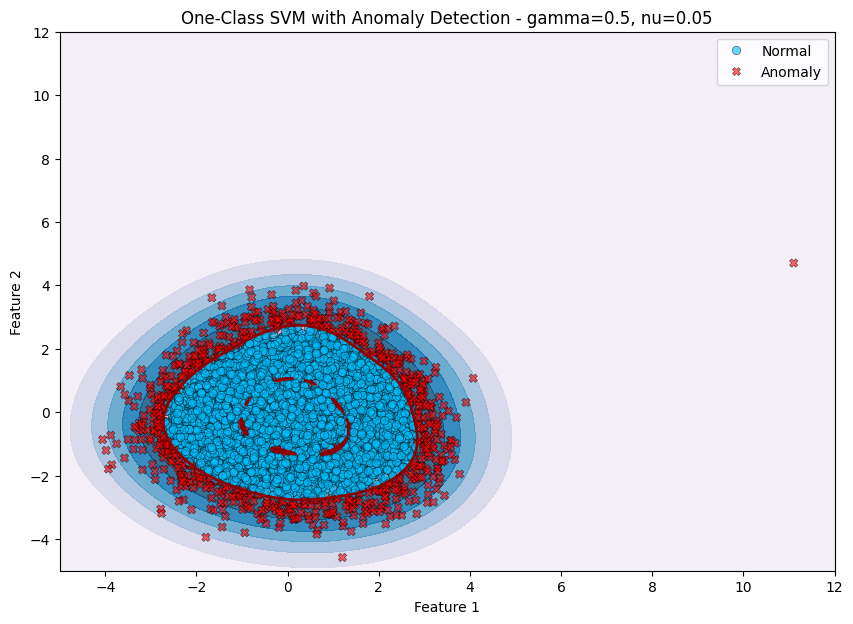

In [ ]:
# Plot the model
model = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.05)
model.fit(X_pca)
plot_model(model, X_pca, "One-Class SVM with Anomaly Detection - gamma=0.5, nu=0.05")

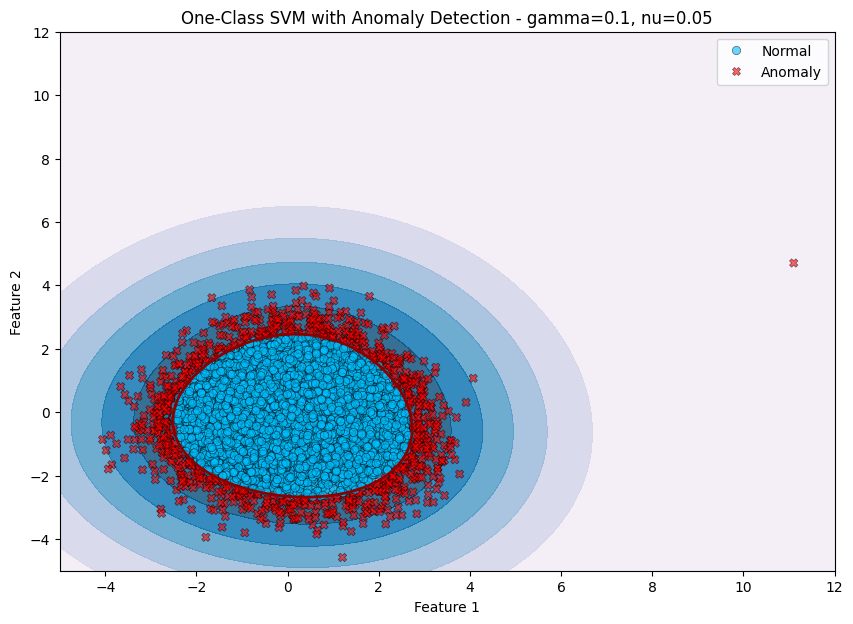

In [ ]:
model_low_nu = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.05)
model_low_nu.fit(X_pca)
plot_model(model_low_nu, X_pca, "One-Class SVM with Anomaly Detection - gamma=0.1, nu=0.05")

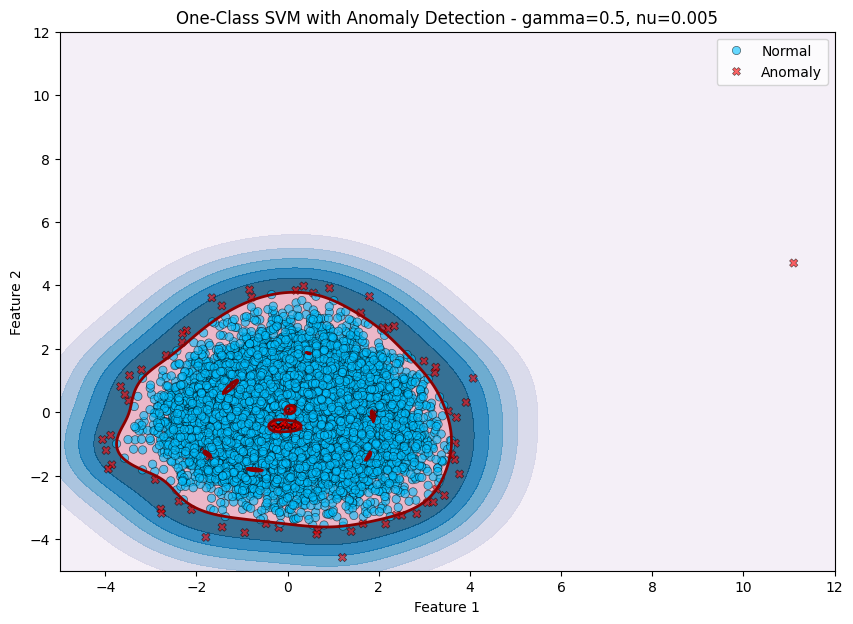

In [ ]:
model_low_nu = OneClassSVM(kernel='rbf', gamma=0.5, nu=0.005)
model_low_nu.fit(X_pca)
plot_model(model_low_nu, X_pca, "One-Class SVM with Anomaly Detection - gamma=0.5, nu=0.005")

**Using Isolation Forest**

In [ ]:
# Import the IsolationForest class from sklearn.ensemble module.
from sklearn.ensemble import IsolationForest

# Fit an Isolation Forest model
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X)

IsolationForest(contamination=0.1, random_state=42)

In [ ]:
# Predict the anomalies (1 for not anomaly, -1 for anomaly).
y_pred = clf.predict(X)

# View output.
y_pred

array([ 1, -1, -1, ...,  1,  1,  1])

In [ ]:
# Add class and anomaly to DataFrame.
data = data[['Engine rpm',	'Lub oil pressure',	'Fuel pressure',	'Coolant pressure',	'lub oil temp',	'Coolant temp']]
data['anomaly'] = y_pred

# View output.
data

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,1
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,-1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,1
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,1
...,...,...,...,...,...,...,...
19530,681,3.598792,7.300853,1.083391,76.206955,69.848780,1
19531,580,2.243040,5.242489,1.471350,76.884907,87.098119,1
19532,616,3.310048,3.787693,6.001031,75.889810,72.220009,1
19533,1163,2.731726,3.703595,2.951684,76.784626,81.400088,1


In [ ]:
# Display outliers
anomalies = data[data['anomaly'] == -1]

# View output.
print(anomalies.shape)
anomalies

(1954, 7)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,-1
7,576,5.495972,13.114658,1.251058,78.091390,71.934674,-1
13,978,4.366676,6.638085,2.829643,88.038301,78.488782,-1
16,1023,2.008806,6.636910,3.409817,86.485544,77.354678,-1
...,...,...,...,...,...,...,...
19433,986,2.929212,14.431486,4.985264,75.477519,69.808798,-1
19448,902,4.758439,16.472671,2.042800,76.032474,83.311262,-1
19451,907,5.651968,8.047249,4.843964,76.607078,84.999955,-1
19467,1320,2.269715,14.557006,1.447439,75.620339,74.135266,-1


In [ ]:
# Import the IsolationForest class from sklearn.ensemble module.
from sklearn.ensemble import IsolationForest

# Fit an Isolation Forest model
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(X)

IsolationForest(contamination=0.05, random_state=42)

In [ ]:
# Predict the anomalies (1 for not anomaly, -1 for anomaly).
y_pred = clf.predict(X)

# View output.
y_pred

array([ 1, -1,  1, ...,  1,  1,  1])

In [ ]:
# Add class and anomaly to DataFrame.
data_if = data[['Engine rpm',	'Lub oil pressure',	'Fuel pressure',	'Coolant pressure',	'lub oil temp',	'Coolant temp']]
data_if['anomaly'] = y_pred

# View output.
data_if

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,1
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,1
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,1
...,...,...,...,...,...,...,...
19530,681,3.598792,7.300853,1.083391,76.206955,69.848780,1
19531,580,2.243040,5.242489,1.471350,76.884907,87.098119,1
19532,616,3.310048,3.787693,6.001031,75.889810,72.220009,1
19533,1163,2.731726,3.703595,2.951684,76.784626,81.400088,1


In [ ]:
# Display outliers
anomalies = data_if[data_if['anomaly'] == -1]

# View output.
print(anomalies.shape)
anomalies

(977, 7)


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1
17,1312,5.963439,7.563578,5.931953,77.738876,88.661972,-1
35,1374,2.543575,8.641020,1.541131,82.268575,66.810303,-1
113,1495,3.276230,3.714396,2.495264,85.053243,75.743004,-1
131,830,3.231908,13.479172,2.568096,87.480362,73.428213,-1
...,...,...,...,...,...,...,...
19343,1475,2.184002,6.558549,1.265442,84.933480,88.088609,-1
19370,740,2.792556,11.359028,1.580190,88.791884,70.047659,-1
19375,999,0.126660,5.106325,3.938253,74.645346,92.353698,-1
19433,986,2.929212,14.431486,4.985264,75.477519,69.808798,-1


In [ ]:
# To visualise in 2D, reduce the dimension to 2 variables using PCA
X = data_if.iloc[:, :6].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

# Apply PCA, reducing the data dimension to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(19535, 2)

In [ ]:
data_if['pca_1'] = X_pca[:, 0]
data_if['pca_2'] = X_pca[:, 1]
data_if.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,anomaly,pca_1,pca_2
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,1,-0.557362,0.906512
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,-1,-2.177170,1.201538
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,1,2.051806,-1.039581
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,1,0.744375,0.501140
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,1,-1.629821,0.473906


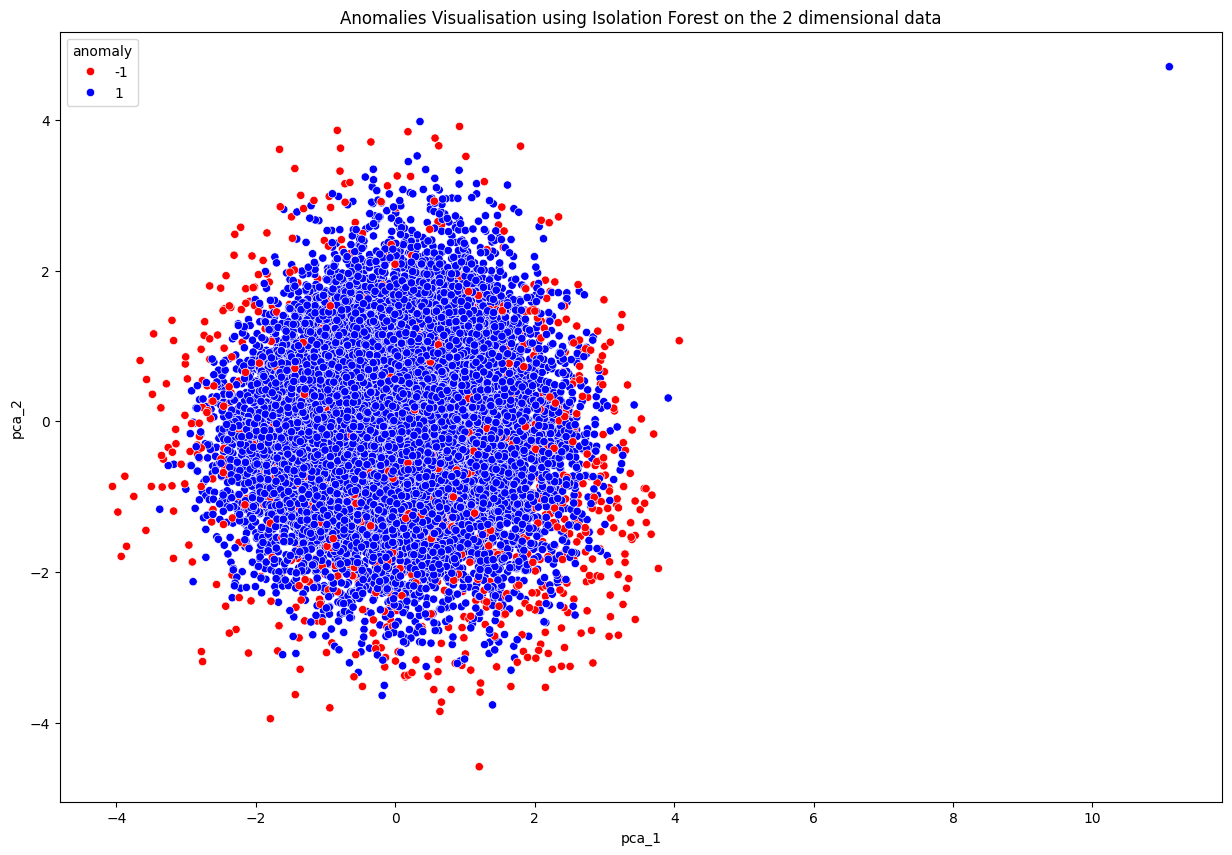

In [ ]:
# Plot setup.
plt.figure(figsize=(15, 10))
plt.title('Anomalies Visualisation using Isolation Forest on the 2 dimensional data')

# Plot anomalies
color_palette = {1: 'blue', -1: 'red'}
sns.scatterplot(data=data_if, x='pca_1', y='pca_2', hue='anomaly', palette=color_palette)

# Show plot
plt.show()

## Conclusion / Observations

This project demonstrates that both statistical and machine learning approaches have complementary strengths in anomaly detection for predictive maintenance applications.

The Interquartile Range (IQR) method offers transparency and interpretability, making it effective when there is enough domian knowledge to define meaningful thresholds and understand feature distributions. It is particularly useful for exploratory analysis and when explaining model outputs to maintenance engineers or decision-makers.

However, if a system is more complex with high-dimensionality, statistical thresholds alone become less practical. In such cases, unsupervised machine learning models such as One-Class SVM and Isolation Forest provide scalable, data-driven alternatives. These models learn patterns of normal behaviour and automatically flag deviations without explicit labels, which is valuable when domain knowledge or labelled fault data is limited.

Among the approaches tested, the Isolation Forest model demonstrated the best balance between computational efficiency, scalability, and interpretability. It successfully identified anomalous operating conditions linked to extreme variations in coolant temperature and lubrication pressures - potential indicators of early mechanical stress or engine malfunction.

Overall, combining both statistical and machine learning methods enabled a more robust predictive maintenance strategy: statistical methods for interpretability and explainability, and ML models for adaptive, real-time anomaly detection in a complex, sensor-rich environment such as this ship engine use case.


### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]